In [1]:
%reset
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
(train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.boston_housing.load_data()

In [3]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

def normalize(data, mean, std):
    result = data.copy()
    result -= mean
    result /= std
    return result

train_data_norm = normalize(train_data, mean, std)
test_data_norm = normalize(test_data, mean, std)

In [4]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(train_data_norm.shape[1],)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [6]:
%%time
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


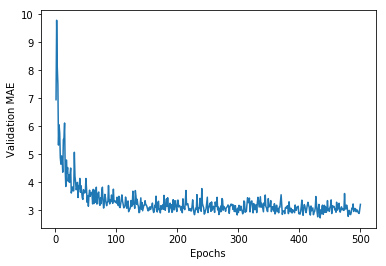

In [9]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

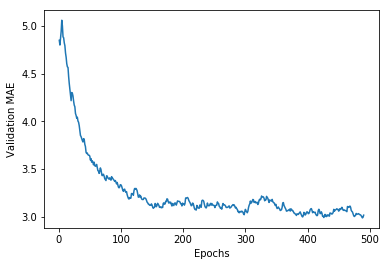

In [10]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()